In [1]:
import chess
import chess.pgn
import chess.svg
import chess.engine
from IPython.display import SVG

import sys
import random
import time

import math
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [20]:
class Knightingale:
    '''
    A deep learning chess engine that leverages the architectures of Block-Recurrent Transformers (Hutchins, D., Schlag, I., Wu, Y., Dyer, E., & Neyshabur, B. (2022). Block-Recurrent Transformers. ArXiv. /abs/2203.07852)
    with Vision Transformers (ViT) (Alexey Dosovitskiy, Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Thomas Unterthiner, Mostafa Dehghani, Matthias Minderer, Georg Heigold, Sylvain Gelly, Jakob Uszkoreit,
    and Neil Houlsby. An image is worth 16x16 words: Transformers for image recognition at scale. In ICLR, 2021.)
    
    The engine utilizes the hybrid transformer architecture to evaluate positions and is trained upon completed chess games.
    Instead of using genetic algorithms or reinforcment learning to train the model, it is trained through recursive backpropagation
    based upon the difference between the actual score of the game (-1 for black, 0 for draw, and 1 for white) with the predicted score
    '''
    
    def __init__(self, table_size, is_white, board):
        self.TABLE_LIMIT = table_size
        self.search_table = dict()
        self.best_move = chess.Move.null()
        self.is_white = is_white
        self.board = board
        self.zobTable = [[[random.randint(1,2**64 - 1) for i in range(12)]for j in range(8)]for k in range(8)]
        self.time = 0
        
    
    def search(self, max_depth, time_limit):
        self.time = time.time()
        best_score = -math.inf
        alpha = -math.inf
        beta = math.inf
        depth = max_depth
        for move in self.board.legal_moves:
            self.board.push(move)
            board_value = -self.negamax(-beta, -alpha, depth - 1)
            if board_value > best_score:
                best_score = board_value
                self.best_move = move
            if board_value > alpha:
                alpha = board_value
            self.board.pop()
    
    def negamax(self, alpha, beta, depth):
        best_score = -math.inf
        if depth == 0:
            return self.quiesce(alpha, beta)
        for move in self.board.legal_moves:
            self.board.push(move)
            score = -self.negamax(-beta, -alpha, depth-1)
            self.board.pop()
            if score >= beta:
                return score
            if score > best_score:
                best_score = score
            if score > alpha:
                alpha = score
        return best_score
    
    def quiesce(self, alpha, beta):
        stand_pat = self.evaluate()
        
        if not self.is_white:
            stand_pat *= -1
        
        if stand_pat >= beta:
            return beta
        if alpha < stand_pat:
            alpha = stand_pat
        
        for move in self.board.legal_moves:
            if self.board.is_capture(move):
                self.board.push(move)
                score = -self.quiesce(-beta, -alpha)
                self.board.pop()
                
                if score >= beta:
                    return beta
                if score > alpha:
                    alpha = score
        return alpha
    
    def zobrist_hash(self):
        mapping = {
            -1: 7,
            -2: 8,
            -3: 9,
            -4: 10,
            -5: 11,
            -6: 12,
            1: 1,
            2: 2,
            3: 3,
            4: 4,
            5: 5,
            6: 6
        }
        
        
        img = self.fen2img(self.board.fen()).astype(np.int32)
        
        hsh = 0
        for i in range(8):
            for j in range(8):
                if img[i, j] != 0:
                    piece = mapping[img[i,j]]
                    hsh ^= self.zobTable[i][j][piece-1]
        return int(hsh) % int(self.TABLE_LIMIT)
    
    def retrieve_table(self):
        pass
    
    def insert_table(self):
        pass
                
    def fen2img(self, fen):
        mapping = {
            'P': 1,
            'N': 2,
            'B': 3,
            'R': 4,
            'Q': 5,
            'K': 6,
            'p': -1,
            'n': -2,
            'b': -3,
            'r': -4,
            'q': -5,
            'k': -6,
            ' ': 0
        }

        pieces = ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k', ' ']
        numbers = range(1,9)

        string_brd = fen.split(' ')[0]
        for num in numbers:
            string_brd = string_brd.replace(str(num), num*' ')

        img = np.zeros((8,8))

        for i, row in enumerate(string_brd.split('/')):
            for j, square in enumerate(row):
                img[i,j] = mapping[square]

        return img
    
    def evaluate(self):
        '''
        Place holder material count until neural network is trained using variation of material count: Counting the piece
        priority value
        
        Board is converted to a numpy array in which pawn, knight, bishop, rook, queen, and king are mapped to 1,2,3,4,5,6 respectively.
        Negative values represent black pieces, positive values represent white
        '''
        if self.board.is_checkmate():
            return -1 if self.board.turn else 1
        if self.board.is_stalemate() or self.board.is_insufficient_material():
            return 0
        return np.sum(self.fen2img(self.board.fen()))     
    
    def ponder(self):
        pass
    
    def make_move(self, depth, time_limit):
        self.search(depth, time_limit)
        self.board.push(self.best_move)
        return self.best_move
    
    def opponent_move(self, move):
        self.board.push(move)
    
    class BRViT:
        '''
        Object representation of a Block-Recurrent Vision Transformer
        '''
        def __init__(self):
            pass

In [27]:
count = 0
movehistory = []
game = chess.pgn.Game()
board = chess.Board()
engine = chess.engine.SimpleEngine.popen_uci("/opt/homebrew/Cellar/stockfish/15.1/bin/stockfish")
knightingale = Knightingale(2**16, False, board.copy())

while not board.is_game_over(claim_draw=True):
    if board.turn:
        count += 1
        print(f'\n{count}]\n')
        move = engine.play(board, chess.engine.Limit(time=0.1))
        movehistory.append(move.move)
        board.push(move.move)
        knightingale.opponent_move(move.move)
        print(board)
        print()
    else:
        move = knightingale.make_move(3)
        movehistory.append(move)
        board.push(move)
        print(board)
        print()
        
game.add_line(movehistory)
game.headers["Result"] = str(board.result(claim_draw=True))

print(game)

SVG(chess.svg.board(board=board, size=400))


1]

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


2]

r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . P P . . .
. . . . . . . .
P P P . . P P P
R N B Q K B N R

r n b q k b . r
p p p p . p p p
. . . . p . . n
. . . . . . . .
. . . P P . . .
. . . . . . . .
P P P . . P P P
R N B Q K B N R


3]

r n b q k b . r
p p p p . p p p
. . . . p . . n
. . . . . . . .
. . . P P . . .
. . . . . N . .
P P P . . P P P
R N B Q K B . R



KeyboardInterrupt: 

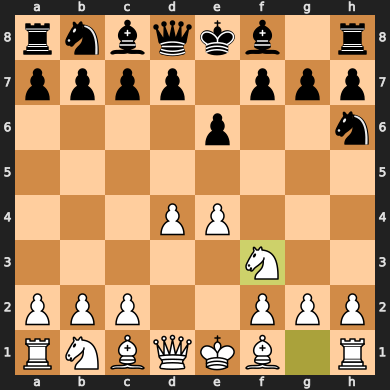

In [28]:
board

In [23]:
knightingale.zobrist_hash()

3826101496

In [26]:
2**16

65536